In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
import pandas as pd
import torch
from tqdm import tqdm
import math
from urllib.request import urlretrieve
from zipfile import ZipFile
import os
import torch.nn as nn
import numpy as np
from math import sqrt
import torch.utils.data as data
from torchvision import transforms
import ast
from torch.nn.utils.rnn import pad_sequence
import pickle
import matplotlib.pyplot as plt

In [ ]:
!pip install pytorch_lightning torch_geometric

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 719.0/719.0 kB 17.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 616.2/616.2 kB 53.1 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 519.2/519.2 kB 40.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 53.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 158.8/158.8 kB 16.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 269.4/269.4 kB 27.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.2/114.2 kB 13.2 MB/s eta 0:00:00
  Created wheel for torch_geometric: filename=torch_geometric-2.3.0-py3-none-any.whl size=909897 sha256=0773e651916d37170c90736bcd017f9580dc513a0ba8460db753ab292bb5f5b3
  Stored in directory: /root/.ca

In [ ]:
print(torch.cuda.is_available())
if torch.cuda.is_available():
  device = torch.device("cuda")
else:
  device = torch.device("cpu")
print("Using device:", device)

True
Using device: cuda


# Load the data

In [ ]:
users = pd.read_csv("/content/drive/MyDrive/WSTM_latest/data/users.csv")
movies = pd.read_csv("/content/drive/MyDrive/WSTM_latest/data/movies.csv")
ratings = pd.read_csv("/content/drive/MyDrive/WSTM_latest/data/ratings.csv")

In [ ]:
train_df = pd.read_csv("/content/drive/MyDrive/WSTM_latest/data/train.csv")
val_df = pd.read_csv("/content/drive/MyDrive/WSTM_latest/data/validation.csv")
test_df = pd.read_csv("/content/drive/MyDrive/WSTM_latest/data/test.csv")

## User analysis

In [ ]:
train_df.head(5)

,user_id,sequence_movie_ids,sequence_ratings,sex,age_group,occupation
0,635,"[480, 2294, 920, 3614, 1286, 1270, 3528, 3948]","[5, 5, 4, 4, 4, 4, 5, 4]",1,6,17
1,635,"[2294, 920, 3614, 1286, 1270, 3528, 3948, 3911]","[5, 4, 4, 4, 4, 5, 4, 4]",1,6,17
2,635,"[920, 3614, 1286, 1270, 3528, 3948, 3911, 3720]","[4, 4, 4, 4, 5, 4, 4, 5]",1,6,17
3,635,"[3614, 1286, 1270, 3528, 3948, 3911, 3720, 3751]","[4, 4, 4, 5, 4, 4, 5, 5]",1,6,17
4,635,"[1286, 1270, 3528, 3948, 3911, 3720, 3751, 2686]","[4, 4, 5, 4, 4, 5, 5, 5]",1,6,17


In [ ]:
ratings["unix_timestamp"].quantile(.80)

975768738.0

In [ ]:
ratings["unix_timestamp"].quantile(.90)

978133376.4

In [ ]:
train_mask = ratings["unix_timestamp"]<975768738.0
train_ratings = ratings[train_mask]

val_mask = (ratings["unix_timestamp"]>975768738.0 )& (ratings["unix_timestamp"]<978133376.4)
val_ratings = ratings[val_mask]

test_mask = ratings["unix_timestamp"]>978133376.4
test_ratings = ratings[test_mask]


In [ ]:
train_ratings.head(5)

,user_id,movie_id,rating,unix_timestamp
94507,635,1251,4,975768620
94513,635,3948,4,975768294
94518,635,1270,4,975768106
94519,635,1279,5,975768520
94522,635,1286,4,975768106


In [ ]:
train_user_samples = train_ratings.groupby("user_id")["user_id"].value_counts().to_dict()

In [ ]:
val_user_samples = val_ratings.groupby("user_id")["user_id"].value_counts().to_dict()

In [ ]:
test_user_samples = test_ratings.groupby("user_id")["user_id"].value_counts().to_dict()

# Model Inference

## Dataloaders

In [ ]:
class MovieDataset(data.Dataset):
    """Movie dataset."""

    def __init__(
        self, ratings_file,test=False
    ):
        """
        Args:
            csv_file (string): Path to the csv file with user,past,future.
        """
        self.ratings_frame = pd.read_csv(
            ratings_file,
            delimiter=",",
            # iterator=True,
        )
        self.test = test

    def __len__(self):
        return len(self.ratings_frame)

    def __getitem__(self, idx):
        data = self.ratings_frame.iloc[idx]
        user_id = data.user_id
        
        movie_history = eval(data.sequence_movie_ids)
        movie_history_ratings = eval(data.sequence_ratings)
        target_movie_id = movie_history[-1:][0]
        target_movie_rating = movie_history_ratings[-1:][0]
        
        movie_history = torch.LongTensor(movie_history[:-1])
        movie_history_ratings = torch.LongTensor(movie_history_ratings[:-1])
        
        sex = data.sex
        age_group = data.age_group
        occupation = data.occupation
        
        return user_id, movie_history, target_movie_id,  movie_history_ratings, target_movie_rating, sex, age_group, occupation

In [ ]:
users = pd.read_csv(
    "/content/drive/MyDrive/WSTM_latest/data/users.csv",
    sep=",",
)

ratings = pd.read_csv(
    "/content/drive/MyDrive/WSTM_latest/data/ratings.csv",
    sep=",",
)

movies = pd.read_csv(
    "/content/drive/MyDrive/WSTM_latest/data/movies.csv", sep=","
)

In [ ]:
train_dataset = MovieDataset("/content/drive/MyDrive/WSTM_latest/data/train.csv")
val_dataset = MovieDataset("/content/drive/MyDrive/WSTM_latest/data/validation.csv")
test_dataset = MovieDataset("/content/drive/MyDrive/WSTM_latest/data/test.csv")

train_dataloader = torch.utils.data.DataLoader(
            train_dataset,
            batch_size=256,
            shuffle=True
        )

val_dataloader = torch.utils.data.DataLoader(
            val_dataset,
            batch_size=512,
            shuffle=True
        )


test_dataloader = torch.utils.data.DataLoader(
            test_dataset,
            batch_size=512,
            shuffle=True
        )

print("Finished Dataloaders")

Finished Dataloaders


In [ ]:
genres = [
    "Action",
    "Adventure",
    "Animation",
    "Children's",
    "Comedy",
    "Crime",
    "Documentary",
    "Drama",
    "Fantasy",
    "Film-Noir",
    "Horror",
    "Musical",
    "Mystery",
    "Romance",
    "Sci-Fi",
    "Thriller",
    "War",
    "Western",
]

## BST

In [ ]:
class PositionalEmbedding(nn.Module):
    """
    Computes positional embedding following "Attention is all you need"
    """

    def __init__(self, max_len, d_model):
        super().__init__()

        # Compute the positional encodings once in log space.
        self.pe = nn.Embedding(max_len, d_model)

    def forward(self, x):
        batch_size = x.size(0)
        return self.pe.weight.unsqueeze(0).repeat(batch_size, 1, 1)


class BST(nn.Module):
    def __init__(self):
        super().__init__()
        
        # Embedding layers
        # Users 
        self.embeddings_user_id = nn.Embedding(
            int(users.user_id.max())+1, int(math.sqrt(users.user_id.max()))+1
        )
        # Users features embeddings
        self.embeddings_user_sex = nn.Embedding(
            len(users.sex.unique()), int(math.sqrt(len(users.sex.unique())))
        )
        self.embeddings_age_group = nn.Embedding(
            len(users.age_group.unique()), int(math.sqrt(len(users.age_group.unique())))
        )
        self.embeddings_user_occupation = nn.Embedding(
            len(users.occupation.unique()), int(math.sqrt(len(users.occupation.unique())))
        )
        self.embeddings_user_zip_code = nn.Embedding(
            len(users.zip_code.unique()), int(math.sqrt(len(users.sex.unique())))
        )
        
        # Movies
        self.embeddings_movie_id = nn.Embedding(
            int(movies.movie_id.max())+1, int(math.sqrt(movies.movie_id.max()))+1
        )
        
        # Movies features embeddings
        genre_vectors = movies[genres].to_numpy()
        self.embeddings_movie_genre = nn.Embedding(
            genre_vectors.shape[0], genre_vectors.shape[1]
        )
        
        
        self.embeddings_movie_year = nn.Embedding(
            len(movies.year.unique()), int(math.sqrt(len(movies.year.unique())))
        )
        
        self.positional_embedding = PositionalEmbedding(8, 63)
        
        # Network
      
        self.transfomerlayer = nn.TransformerEncoderLayer(63, 9, dropout=0.2)
        self.linear = nn.Sequential(
            nn.Linear(
                589,
                1024,
            ),
            nn.LeakyReLU(),
            nn.Linear(1024, 512),
            nn.LeakyReLU(),
            nn.Linear(512, 256),
            nn.LeakyReLU(),
            nn.Linear(256, 1),
        )
        self.criterion = torch.nn.MSELoss()
        self.opt = torch.optim.AdamW(self.parameters(), lr=0.0005)
        


    def encode_input(self,inputs):
        inputs = [x.to(device) for x in inputs]
        user_id, movie_history, target_movie_id,  movie_history_ratings, target_movie_rating, sex, age_group, occupation = inputs
               
        # MOVIES
        movie_history = self.embeddings_movie_id(movie_history)
        target_movie = self.embeddings_movie_id(target_movie_id)
         
        target_movie = torch.unsqueeze(target_movie, 1)
        transfomer_features = torch.cat((movie_history, target_movie),dim=1)

        # USERS
        user_id = self.embeddings_user_id(user_id)
        
        sex = self.embeddings_user_sex(sex)
        age_group = self.embeddings_age_group(age_group)
        occupation = self.embeddings_user_occupation(occupation)
        user_features = torch.cat((user_id, sex, age_group,occupation), 1)
        
        return transfomer_features, user_features, target_movie_rating.float(), movie_history_ratings
    
    def forward(self, batch):
        transfomer_features, user_features, target_movie_rating, movie_history_ratings = self.encode_input(batch)
        positional_embedding = self.positional_embedding(transfomer_features)
      
        transfomer_features = transfomer_features + positional_embedding        
        movie_history_ratings = torch.concat((movie_history_ratings, 5 * torch.ones(movie_history_ratings.size()[0], 1).to(device)), 1)[:, :, None]/5.0

        transfomer_features = transfomer_features * movie_history_ratings

        transformer_output = self.transfomerlayer(transfomer_features)
        transformer_output = torch.flatten(transformer_output,start_dim=1)
        
        #Concat with other features
        features = torch.cat((transformer_output,user_features),dim=1)

        output = self.linear(features)
        return output, target_movie_rating


In [ ]:
def validate (model, data_loader, criterion):
  mae_loss = torch.nn.L1Loss()
  model.eval()
  val_loss = 0.0
  for i, batch_data in enumerate(data_loader):
      
      output, target = model.forward(batch_data)
      output = output.flatten()
      target = target.flatten()

      loss = mae_loss(output, target)
      val_loss += loss.item()

  return val_loss, loss.item()

In [ ]:
bst = BST().to(device)

criterion = torch.nn.MSELoss()
optimizer = torch.optim.AdamW(bst.parameters(), lr=0.0005)
mae_loss = torch.nn.L1Loss()


In [ ]:
bst.load_state_dict(torch.load("/content/drive/MyDrive/WSTM_latest/weights/bst_9_head_noemb.pth", map_location=device))

<All keys matched successfully>

In [ ]:
from torch.utils.data import dataloader
user_loss_map = {}
no_train_data = []
for i,key in enumerate(list(train_user_samples.keys())):
  user = key[0]
  user_mask = (train_df["user_id"] == user)
  df = train_df[user_mask]
  if len(df)>0:
    df.to_csv("tmp.csv", index=False)
    tmp_dataset = MovieDataset("tmp.csv")
    dataloader = torch.utils.data.DataLoader(
              tmp_dataset,
              batch_size=512,
              shuffle=True
          )
    
    total_loss, mae_loss = validate(bst, dataloader, criterion)
    user_loss_map[user] = (total_loss, mae_loss)
  
  else:
    no_train_data.append(user)

  if i%100 == 0:
    print("completed ", i)
    

  



In [ ]:
from torch.utils.data import dataloader

val_user_loss_map = {}
no_val_data = []

for i,key in enumerate(list(val_user_samples.keys())):
  user = key[0]
  user_mask = (val_df["user_id"] == user)
  df = val_df[user_mask]
  if len(df)>0:
    df.to_csv("tmp.csv", index=False)
    tmp_dataset = MovieDataset("tmp.csv")
    dataloader = torch.utils.data.DataLoader(
              tmp_dataset,
              batch_size=512,
              shuffle=True
          )
    
    total_loss, mae_loss = validate(bst, dataloader, criterion)
    val_user_loss_map[user] = (total_loss, mae_loss)
  else:
    no_val_data.append(user)


  if i%100 == 0:
    print("completed ", i)

  



In [ ]:
from torch.utils.data import dataloader
test_user_loss_map = {}
no_test_data = []

for i,key in enumerate(list(test_user_samples.keys())):
  user = key[0]
  user_mask = (test_df["user_id"] == user)
  df = test_df[user_mask]
  if len(df)>0:
    df.to_csv("tmp.csv", index=False)
    tmp_dataset = MovieDataset("tmp.csv")
    dataloader = torch.utils.data.DataLoader(
              tmp_dataset,
              batch_size=512,
              shuffle=True
          )
    
    total_loss, mae_loss = validate(bst, dataloader, criterion)
    test_user_loss_map[user] = (total_loss, mae_loss)
  else:
    no_test_data.append(user)

  if i%100 == 0:
    print("completed ", i)

  



completed  0
completed  100
completed  200
completed  300
completed  400
completed  500
completed  600
completed  700
completed  800
completed  900
completed  1000
completed  1100
completed  1200


In [ ]:
with open("/content/drive/MyDrive/WSTM_latest/misc_files/train_user_count.pkl", "wb+") as f:
  pickle.dump(train_user_samples, f)

with open("/content/drive/MyDrive/WSTM_latest/misc_files/val_user_count.pkl", "wb+") as f:
  pickle.dump(val_user_samples, f)

with open("/content/drive/MyDrive/WSTM_latest/misc_files/test_user_count.pkl", "wb+") as f:
  pickle.dump(val_user_samples, f)

In [ ]:
with open("/content/drive/MyDrive/WSTM_latest/misc_files/train_user_loss.pkl", "wb+") as f:
  pickle.dump(user_loss_map, f)

In [ ]:
with open("/content/drive/MyDrive/WSTM_latest/misc_files/val_user_loss.pkl", "wb+") as f:
  pickle.dump(val_user_loss_map, f)

In [ ]:
with open("/content/drive/MyDrive/WSTM_latest/misc_files/test_user_loss.pkl", "wb+") as f:
  pickle.dump(test_user_loss_map, f)

### Analysis

In [ ]:
train_users = set(list(train_user_samples.keys()))
val_users = set(list(val_user_samples.keys()))
test_users = set(list(test_user_samples.keys()))

In [ ]:
print("Total nos of users in train: ", len(train_users))
print("Total nos of users in val: ", len(val_users))
print("Total nos of users in test: ", len(test_users))

In [ ]:
print("Nos of val users not in train: ", len(val_users.difference(train_users)))
print("Nos of test users not in train: ", len(test_users.difference(train_users)))

In [ ]:
def process_user_loss(user_loss_map, user_count):
  d = {}
  for key,val in user_loss_map.items():
    d[key] = val[0]
  
  mean = np.mean(list(d.values()))
  std_dev = np.std(list(d.values()))
  
  loss_values = []
  sample_count = []


  print("Mean: ", mean)
  print("std_dev: ", std_dev)
  print(len(d))
  
  users = []

  for key,val in d.items():
    loss_values.append(val)
    
    if (key,key) in user_count:
      sample_count.append(user_count[(key,key)])
    else:
      sample_count.append(0)

      #print("User: "+str(key)+ " loss: "+str(val)+ " nos: "+str(user_count[(key, key)]))
  
  return loss_values, sample_count

  


  

In [ ]:
with open("/content/drive/MyDrive/WSTM_latest/misc_files/train_user_count.pkl", "rb") as f:
  train_user_samples = pickle.load(f)

with open("/content/drive/MyDrive/WSTM_latest/misc_files/val_user_loss.pkl", "rb") as f:
  bst_val_loss_map = pickle.load(f)

with open("/content/drive/MyDrive/WSTM_latest/misc_files/test_user_loss.pkl", "rb") as f:
  bst_test_loss_map = pickle.load(f)

In [ ]:
colors = ['red' if x==0 else 'blue' for x in val_sample]

plt.scatter(val_sample, val_loss, c=colors)

<BarContainer object of 880 artists>

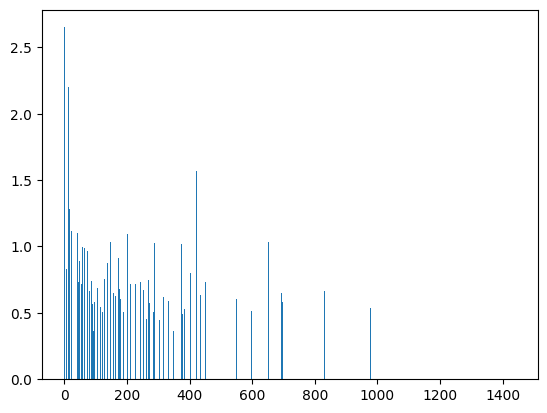

In [ ]:
plt.bar(val_sample, val_loss)

In [ ]:
test_loss, test_sample = process_user_loss(test_user_loss_map, train_user_samples)

Mean:  0.7701966251485312
std_dev:  0.24648699888603187
995


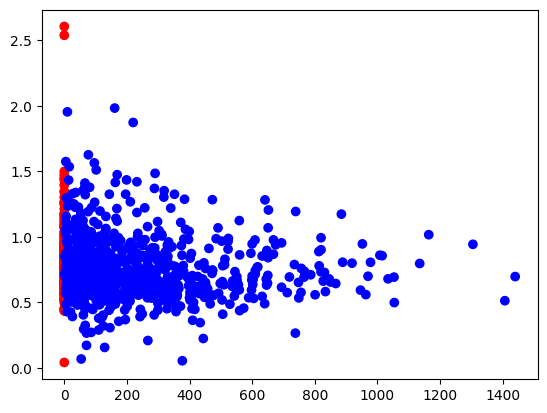

In [ ]:
colors = ['red' if x==0 else 'blue' for x in test_sample]

plt.scatter(test_sample, test_loss, c=colors)

<BarContainer object of 995 artists>

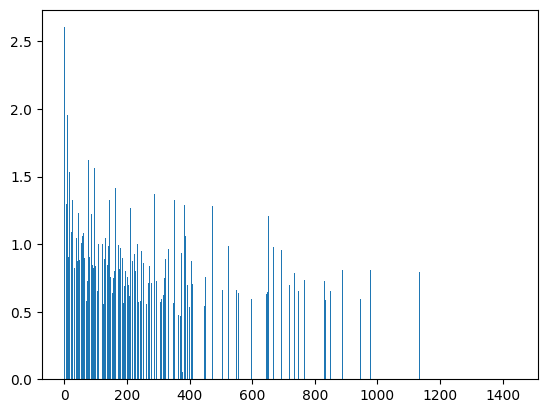

In [ ]:
plt.bar(test_sample, test_loss)

## NGCF

In [ ]:
from torch_geometric.data import Data
from torch_geometric.utils import to_dense_adj


In [ ]:
MAX_USER_ID = ratings.user_id.max()

In [ ]:
ratings_std = ratings.copy(deep=True)
ratings_std['movie_id'] = ratings['movie_id'] + MAX_USER_ID
ratings_std['rating'] = ratings['rating']

edge_list = [list(ratings_std['user_id']), list(ratings_std['movie_id'])]
edge_index = torch.tensor(edge_list, dtype=torch.long)

adj_list = to_dense_adj(edge_index)[0]
print(adj_list.shape)
ratings_list = torch.tensor(list(ratings_std['rating']), dtype=torch.float)

torch.Size([9993, 9993])


In [ ]:
def generate_ngcf_dataset(ratings):
  ratings_std = ratings.copy(deep=True)
  ratings_std['movie_id'] = ratings['movie_id'] + MAX_USER_ID
  ratings_std['rating'] = ratings['rating']

  edge_index = torch.tensor(edge_list, dtype=torch.long)

  adj_list = to_dense_adj(edge_index)[0]
  print(adj_list.shape)
  ratings_list = torch.tensor(list(ratings_std['rating']), dtype=torch.float)

  dataset = Data(x=adj_list, y=ratings_list, edge_index=edge_index)

  train_num = int(dataset.num_edges * 0.8)
  test_num = dataset.num_edges - train_num
  print(train_num)
  
  dataset.train_mask = torch.cat((torch.ones(train_num, 1, dtype=torch.int), torch.zeros(test_num, 1, dtype=torch.int)))
  dataset.test_mask = torch.cat((torch.zeros(test_num, 1, dtype=torch.int), torch.ones(test_num, 1, dtype=torch.int)))

  data = dataset.to(device)
  return data

  

In [ ]:
train_data = generate_ngcf_dataset(train_ratings)

torch.Size([9993, 9993])
800167


In [ ]:
val_data = generate_ngcf_dataset(val_ratings)


torch.Size([9993, 9993])
800167


In [ ]:
test_data = generate_ngcf_dataset(test_ratings)

torch.Size([9993, 9993])
800167


In [ ]:
import torch.nn.functional as F
from torch_geometric.nn import GCNConv

class GCN_NGCF(torch.nn.Module):
    def __init__(self, dataset, hidden_channels_gcn=32, hidden_channels_fc=512, dropout_probability=0.2):
        super().__init__()
        self.dataset = dataset
        self.conv1 = GCNConv(dataset.num_node_features, hidden_channels_gcn)
        self.conv2 = GCNConv(hidden_channels_gcn, hidden_channels_gcn)
        self.dropout_p = dropout_probability
        self.fc1 = nn.Linear(in_features=(2 * hidden_channels_gcn), out_features=hidden_channels_fc)
        self.fc2 = nn.Linear(in_features=hidden_channels_fc, out_features=hidden_channels_fc)
        self.output = nn.Linear(in_features=hidden_channels_fc, out_features=1)
        self.relu = nn.ReLU()

    def forward(self, data):
        x, edge_index = data.x, data.edge_index

        out = self.conv1(x, edge_index)
        out = F.relu(out)
        out = F.dropout(out, p=self.dropout_p, training=self.training)
        out = self.conv2(out, edge_index)
        out = F.relu(out)
        out = F.dropout(out, p=self.dropout_p, training=self.training)

        out = self.fc1(torch.cat((out[data.edge_index.T[:, 0]], out[data.edge_index.T[:, 1]]), dim=1).type(torch.float))
        out = self.relu(out)
        out = self.fc2(out)
        out = self.relu(out)
        out = self.output(out)
        

        return out

In [ ]:
criterion = nn.MSELoss()
mae_loss = nn.L1Loss()
mae_loss_indiv = nn.L1Loss(reduction='none')

In [ ]:
gcn_model = GCN_NGCF(train_data, hidden_channels_gcn=18, hidden_channels_fc=128, dropout_probability=0.2).to(device)
gcn_model.load_state_dict(torch.load("/content/drive/MyDrive/WSTM_latest/weights/ngcf.pth"))
gcn_model.eval()

GCN_NGCF(
  (conv1): GCNConv(9993, 18)
  (conv2): GCNConv(18, 18)
  (fc1): Linear(in_features=36, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=128, bias=True)
  (output): Linear(in_features=128, out_features=1, bias=True)
  (relu): ReLU()
)

### Analysis

In [ ]:
with open("/content/drive/MyDrive/WSTM_latest/misc_files/train_user_count.pkl", "rb") as f:
  train_sample = pickle.load(f)

In [ ]:
train_preds = gcn_model(train_data).flatten()
print("MSE: ",criterion(train_preds[:train_data.y.shape[0]], train_data.y))
print("MAE: ",mae_loss(train_preds[:train_data.y.shape[0]], train_data.y))

MSE:  tensor(2.1525, device='cuda:0', grad_fn=<MseLossBackward0>)
MAE:  tensor(1.1732, device='cuda:0', grad_fn=<MeanBackward0>)


In [ ]:
val_preds = gcn_model(val_data).flatten()
print("MSE: ", criterion(val_preds[:val_data.y.shape[0]], val_data.y))
print("MAE: ",mae_loss(val_preds[:val_data.y.shape[0]], val_data.y) )
val_preds_loss = mae_loss_indiv(val_preds[:val_data.y.shape[0]], val_data.y) 

MSE:  tensor(2.1442, device='cuda:0', grad_fn=<MseLossBackward0>)
MAE:  tensor(1.1695, device='cuda:0', grad_fn=<MeanBackward0>)


In [ ]:
test_preds = gcn_model(test_data).flatten()
print("MSE: ", criterion(test_preds[:test_data.y.shape[0]], test_data.y))
print("MAE: ", mae_loss(test_preds[:test_data.y.shape[0]], test_data.y))
test_preds_loss = mae_loss_indiv(test_preds[:test_data.y.shape[0]], test_data.y)

MSE:  tensor(2.0685, device='cuda:0', grad_fn=<MseLossBackward0>)
MAE:  tensor(1.1481, device='cuda:0', grad_fn=<MeanBackward0>)


In [ ]:
import collections

def calc_user_loss(user_lst, loss_lst, user_sample_count):
  loss = []
  nos_samples = []
  ngcf_user_loss = {}

  user_loss_map = collections.defaultdict(list)

  for i in range(len(user_lst)):
    user = user_lst[i]
    user_loss_map[user].append(loss_lst[i])

  for user_id, user_loss in user_loss_map.items():
    avg_loss = np.mean(user_loss)
    loss.append(avg_loss)
    ngcf_user_loss[user_id] = avg_loss
    
    if (user_id, user_id) in user_sample_count:
      nos_samples.append(user_sample_count[(user_id, user_id)])
    else:
      nos_samples.append(0)
    
  return loss, nos_samples, ngcf_user_loss

    
    

In [ ]:
val_user_list = val_ratings["user_id"].tolist()
val_loss, val_user_samples, ngcf_val_user_loss = calc_user_loss(val_user_list, val_preds_loss.tolist(), train_sample)

In [ ]:
test_user_list = test_ratings["user_id"].tolist()
test_loss, test_user_samples, ngcf_test_user_loss = calc_user_loss(test_user_list, test_preds_loss.tolist(), train_sample)

In [ ]:
import matplotlib.pyplot as plt

In [ ]:
colors = ['red' if x==0 else 'blue' for x in val_user_samples]

plt.scatter(val_user_samples, val_loss, c=colors)

In [ ]:
plt.bar(val_user_samples, val_loss)

In [ ]:
colors = ['red' if x==0 else 'blue' for x in test_user_samples]

plt.scatter(test_user_samples, test_loss, c=colors)

In [ ]:
plt.bar(test_user_samples, test_loss)

## Comparing BST and NGCF

In [ ]:
train_users = set(train_ratings["user_id"].tolist())
val_users = set(val_ratings["user_id"].tolist())
test_users = set(test_ratings["user_id"].tolist())


In [ ]:
#cold start problem for validation set

users_in_val_not_train = list(val_users.difference(train_users))

count = 0
no_bst = 0
diff = []

for user in users_in_val_not_train:
  if user in bst_val_loss_map:
    bst_loss = bst_val_loss_map[user][0]
    ngcf_loss = ngcf_val_user_loss[user]

    if bst_loss>ngcf_loss:
      count+=1
    else:
      diff.append(ngcf_loss-bst_loss)
                  
  else:
    no_bst+=1

print("Total number of users with cold start problem in validation set: ", len(users_in_val_not_train))
print("NGCF better for cold start: ", count)
print("Users with no bst: ", no_bst)

Total number of users with cold start problem in validation set:  611
NGCF better for cold start:  41
Users with no bst:  12


In [ ]:
print("avg increase in val loss: ", np.mean(diff))

avg increase in val loss:  0.37213399227894595


In [ ]:
#cold start problem for test set

users_in_test_not_train = list(test_users.difference(train_users))

count = 0
no_bst = 0
test_diff = []

for user in users_in_test_not_train:
  if user in bst_test_loss_map:
    bst_loss = bst_test_loss_map[user][0]
    ngcf_loss = ngcf_test_user_loss[user]

    if bst_loss>ngcf_loss:
      count+=1
    else:
      test_diff.append(ngcf_loss-bst_loss)
  else:
    no_bst+=1


print("Total number of users with cold start problem in test set: ", len(users_in_test_not_train))
print("NGCF better for cold start: ", count)
print("Users with no bst: ", no_bst)

Total number of users with cold start problem in test set:  200
NGCF better for cold start:  20
Users with no bst:  26


In [ ]:
print("avg increase in test loss: ", np.mean(test_diff))

avg increase in test loss:  0.363258457915351


## BST+NGCF

In [ ]:
ngcf_emb = pickle.load(open("/content/drive/MyDrive/WSTM_latest/data/ngcf_emb_18.pkl", "rb"))

In [ ]:
num_users = len(users)

In [ ]:
genres = [
    "Action",
    "Adventure",
    "Animation",
    "Children's",
    "Comedy",
    "Crime",
    "Documentary",
    "Drama",
    "Fantasy",
    "Film-Noir",
    "Horror",
    "Musical",
    "Mystery",
    "Romance",
    "Sci-Fi",
    "Thriller",
    "War",
    "Western",
]

In [ ]:
class PositionalEmbedding(nn.Module):
    """
    Computes positional embedding following "Attention is all you need"
    """

    def __init__(self, max_len, d_model):
        super().__init__()

        # Compute the positional encodings once in log space.
        self.pe = nn.Embedding(max_len, d_model)

    def forward(self, x):
        batch_size = x.size(0)
        return self.pe.weight.unsqueeze(0).repeat(batch_size, 1, 1)


class NGCF_BST(nn.Module):
    def __init__(self):
        super().__init__()
        
        # Embedding layers
        ##Users 
        self.embeddings_user_id = nn.Embedding(
            int(users.user_id.max())+1, int(math.sqrt(users.user_id.max()))+1
        )
        # Users features embeddings
        self.embeddings_user_sex = nn.Embedding(
            len(users.sex.unique()), int(math.sqrt(len(users.sex.unique())))
        )
        self.embeddings_age_group = nn.Embedding(
            len(users.age_group.unique()), int(math.sqrt(len(users.age_group.unique())))
        )
        self.embeddings_user_occupation = nn.Embedding(
            len(users.occupation.unique()), int(math.sqrt(len(users.occupation.unique())))
        )
        self.embeddings_user_zip_code = nn.Embedding(
            len(users.zip_code.unique()), int(math.sqrt(len(users.sex.unique())))
        )
        
        # Movies
        self.embeddings_movie_id = nn.Embedding(
            int(movies.movie_id.max())+1, int(math.sqrt(movies.movie_id.max()))+1
        )
        
        # Movies features embeddings
        genre_vectors = movies[genres].to_numpy()
        self.embeddings_movie_genre = nn.Embedding(
            genre_vectors.shape[0], genre_vectors.shape[1]
        )
        
        
        
        self.embeddings_movie_year = nn.Embedding(
            len(movies.year.unique()), int(math.sqrt(len(movies.year.unique())))
        )

        self.movie_ngcf_emb_extend = torch.nn.Linear(
            18, 36
        )
        self.user_ngcf_emb_extend = torch.nn.Linear(
            18, 36
        )
        
        
        self.positional_embedding = PositionalEmbedding(8, 99)
        
        # Network
        
        self.transfomerlayer = nn.TransformerEncoderLayer(99, 9, dropout=0.2)
        
        self.linear = nn.Sequential(
            nn.Linear(
                
                913,
                1024,
            ),
            nn.LeakyReLU(),
            nn.Linear(1024, 512),
            nn.LeakyReLU(),
            nn.Linear(512, 256),
            nn.LeakyReLU(),
            nn.Linear(256, 1),
        )
        self.criterion = torch.nn.MSELoss()
        
        self.opt = torch.optim.AdamW(self.parameters(), lr=0.0005)
        


    def encode_input(self,inputs):
        inputs = [x.to(device) for x in inputs]
        user_id, movie_history, target_movie_id,  movie_history_ratings, target_movie_rating, sex, age_group, occupation = inputs
               
        # MOVIES
        movie_id_ngcf = movie_history + num_users
        movie_ngcf_emb = ngcf_emb[movie_id_ngcf]
        movie_ngcf_extend = self.movie_ngcf_emb_extend(movie_ngcf_emb)

        movie_history = self.embeddings_movie_id(movie_history)
        target_movie = self.embeddings_movie_id(target_movie_id)
        
        movie_history = torch.cat((movie_history, movie_ngcf_extend), dim=2)
        

        target_movie_ngcf_emb = ngcf_emb[target_movie_id]
        target_movie_ngcf_extend = self.movie_ngcf_emb_extend(target_movie_ngcf_emb)

        target_movie = torch.cat((target_movie, target_movie_ngcf_extend), dim=1)
        
        target_movie = torch.unsqueeze(target_movie, 1)
        transfomer_features = torch.cat((movie_history, target_movie),dim=1)
        

        #USERS
        ngcf_user_emb = ngcf_emb[user_id]
        ngcf_user_extend = self.user_ngcf_emb_extend(ngcf_user_emb)
        user_id = self.embeddings_user_id(user_id)
        
        sex = self.embeddings_user_sex(sex)
        age_group = self.embeddings_age_group(age_group)
        occupation = self.embeddings_user_occupation(occupation)

        
        user_features = torch.cat((user_id, sex, age_group, occupation, ngcf_user_extend), 1)
        
        
        return transfomer_features, user_features, target_movie_rating.float(), movie_history_ratings
    
    def forward(self, batch):
        transfomer_features, user_features, target_movie_rating, movie_history_ratings = self.encode_input(batch)
        positional_embedding = self.positional_embedding(transfomer_features)
        
        transfomer_features = transfomer_features + positional_embedding        
        movie_history_ratings = torch.concat((movie_history_ratings, 5 * torch.ones(movie_history_ratings.size()[0], 1).to(device)), 1)[:, :, None]/5.0

        transfomer_features = transfomer_features * movie_history_ratings

        transformer_output = self.transfomerlayer(transfomer_features)
        transformer_output = torch.flatten(transformer_output,start_dim=1)
        
        #Concat with other features
        features = torch.cat((transformer_output,user_features),dim=1)

        output = self.linear(features)
        return output, target_movie_rating


In [ ]:
ngcf_bst = NGCF_BST().to(device)
ngcf_bst.load_state_dict(torch.load("/content/drive/MyDrive/WSTM_latest/weights/ngcf_bst.pth"))

<All keys matched successfully>

In [ ]:
train_dataset = MovieDataset("/content/drive/MyDrive/WSTM_latest/data/train.csv")
val_dataset = MovieDataset("/content/drive/MyDrive/WSTM_latest/data/validation.csv")
test_dataset = MovieDataset("/content/drive/MyDrive/WSTM_latest/data/test.csv")

train_dataloader = torch.utils.data.DataLoader(
            train_dataset,
            batch_size=256,
            shuffle=True
        )
val_dataloader = torch.utils.data.DataLoader(
            val_dataset,
            batch_size=512,
            shuffle=True
        )
test_dataloader = torch.utils.data.DataLoader(
            test_dataset,
            batch_size=512,
            shuffle=True
        )

print("Finished Dataloaders")

Finished Dataloaders


In [ ]:
def validate (model, data_loader, criterion):
  mae_loss_indiv = torch.nn.L1Loss(reduction='none')
  mae_loss = torch.nn.L1Loss()

  model.eval()
  val_loss = 0.0
  user_loss_map = collections.defaultdict(list)

  for i, batch_data in enumerate(data_loader):
      
      output, target = model.forward(batch_data)
      output = output.flatten()
      target = target.flatten()

      loss = mae_loss_indiv(output, target)
      val_loss += mae_loss(output, target).item()

      user_lst = batch_data[0]
      loss_lst = loss.tolist()

      for i,user in enumerate(user_lst):
        user_loss_map[user.item()].append(loss_lst[i])

      
        
  final_usr_loss = {}

  for user, loss in user_loss_map.items():
    final_usr_loss[user] = np.mean(loss)


  return val_loss, final_usr_loss

In [ ]:
val_loss, ngcf_bst_val_user_loss = validate(ngcf_bst, val_dataloader, None)

In [ ]:
print("BST+NGCF val_loss: ", val_loss/len(val_dataloader))

BST+NGCF val_loss:  0.7461204419533412


In [ ]:
test_loss, ngcf_bst_test_user_loss = validate(ngcf_bst, test_dataloader, None)
print("BST+NGCF test_loss: ", test_loss/len(test_dataloader))

BST+NGCF test_loss:  0.7210942160483845


## NGCF + KG + BST

In [ ]:
ngcf_emb = pickle.load(open("/content/drive/MyDrive/WSTM_latest/weights/kg_emb.pkl", "rb"))
ngcf_emb = ngcf_emb.to(device)

In [ ]:
class PositionalEmbedding(nn.Module):
    """
    Computes positional embedding following "Attention is all you need"
    """

    def __init__(self, max_len, d_model):
        super().__init__()

        # Compute the positional encodings once in log space.
        self.pe = nn.Embedding(max_len, d_model)

    def forward(self, x):
        batch_size = x.size(0)
        return self.pe.weight.unsqueeze(0).repeat(batch_size, 1, 1)


class NGCF_KG_BST(nn.Module):
    def __init__(self):
        super().__init__()
        
        # Embedding layers
        #Users 
        self.embeddings_user_id = nn.Embedding(
            int(users.user_id.max())+1, int(math.sqrt(users.user_id.max()))+1
        )
        ##Users features embeddings
        self.embeddings_user_sex = nn.Embedding(
            len(users.sex.unique()), int(math.sqrt(len(users.sex.unique())))
        )
        self.embeddings_age_group = nn.Embedding(
            len(users.age_group.unique()), int(math.sqrt(len(users.age_group.unique())))
        )
        self.embeddings_user_occupation = nn.Embedding(
            len(users.occupation.unique()), int(math.sqrt(len(users.occupation.unique())))
        )
        self.embeddings_user_zip_code = nn.Embedding(
            len(users.zip_code.unique()), int(math.sqrt(len(users.sex.unique())))
        )
        
        # Movies
        self.embeddings_movie_id = nn.Embedding(
            int(movies.movie_id.max())+1, int(math.sqrt(movies.movie_id.max()))+1
        )
        
        # Movies features embeddings
        genre_vectors = movies[genres].to_numpy()
        self.embeddings_movie_genre = nn.Embedding(
            genre_vectors.shape[0], genre_vectors.shape[1]
        )
        
        
        
        self.embeddings_movie_year = nn.Embedding(
            len(movies.year.unique()), int(math.sqrt(len(movies.year.unique())))
        )

        self.movie_ngcf_emb_extend = torch.nn.Linear(
            50, 72
        )
        self.user_ngcf_emb_extend = torch.nn.Linear(
            50, 72
        )
        
        self.positional_embedding = PositionalEmbedding(8, 135)
        
        # Network
        
        self.transfomerlayer = nn.TransformerEncoderLayer(135, 15, dropout=0.2)
        
        self.linear = nn.Sequential(
            nn.Linear(
                1237,
                1024,
            ),
            nn.LeakyReLU(),
            nn.Linear(1024, 512),
            nn.LeakyReLU(),
            nn.Linear(512, 256),
            nn.LeakyReLU(),
            nn.Linear(256, 1),
        )
        self.criterion = torch.nn.MSELoss()
        self.opt = torch.optim.AdamW(self.parameters(), lr=0.0005)
        


    def encode_input(self,inputs):
        inputs = [x.to(device) for x in inputs]
        user_id, movie_history, target_movie_id,  movie_history_ratings, target_movie_rating, sex, age_group, occupation = inputs
               
        #MOVIES
        movie_id_ngcf = movie_history + num_users
        movie_ngcf_emb = ngcf_emb[movie_id_ngcf]
        movie_ngcf_extend = self.movie_ngcf_emb_extend(movie_ngcf_emb)

        movie_history = self.embeddings_movie_id(movie_history)
        target_movie = self.embeddings_movie_id(target_movie_id)
      
        movie_history = torch.cat((movie_history, movie_ngcf_extend), dim=2)
        

        target_movie_ngcf_emb = ngcf_emb[target_movie_id]
        target_movie_ngcf_extend = self.movie_ngcf_emb_extend(target_movie_ngcf_emb)

        target_movie = torch.cat((target_movie, target_movie_ngcf_extend), dim=1)
        
        target_movie = torch.unsqueeze(target_movie, 1)
        transfomer_features = torch.cat((movie_history, target_movie),dim=1)
        

        #USERS
        ngcf_user_emb = ngcf_emb[user_id]
        ngcf_user_extend = self.user_ngcf_emb_extend(ngcf_user_emb)
        user_id = self.embeddings_user_id(user_id)
        
        sex = self.embeddings_user_sex(sex)
        age_group = self.embeddings_age_group(age_group)
        occupation = self.embeddings_user_occupation(occupation)

        
        user_features = torch.cat((user_id, sex, age_group, occupation, ngcf_user_extend), 1)
        
        
        return transfomer_features, user_features, target_movie_rating.float(), movie_history_ratings
    
    def forward(self, batch):
        transfomer_features, user_features, target_movie_rating, movie_history_ratings = self.encode_input(batch)
        positional_embedding = self.positional_embedding(transfomer_features)
        
        transfomer_features = transfomer_features + positional_embedding        
        movie_history_ratings = torch.concat((movie_history_ratings, 5 * torch.ones(movie_history_ratings.size()[0], 1).to(device)), 1)[:, :, None]/5.0

        transfomer_features = transfomer_features * movie_history_ratings

        transformer_output = self.transfomerlayer(transfomer_features)
        transformer_output = torch.flatten(transformer_output,start_dim=1)
        
        #Concat with other features
        features = torch.cat((transformer_output,user_features),dim=1)

        output = self.linear(features)
        return output, target_movie_rating


In [ ]:
ngcf_kg_bst = NGCF_KG_BST().to(device)

criterion = torch.nn.MSELoss()
mae_loss = torch.nn.L1Loss()


In [ ]:
ngcf_kg_bst.load_state_dict(torch.load("/content/drive/MyDrive/WSTM_latest/weights/ngcf_bst_kg.pth"))

<All keys matched successfully>

In [ ]:
def validate (model, data_loader, criterion):
  mae_loss_indiv = torch.nn.L1Loss(reduction='none')
  mae_loss = torch.nn.L1Loss()

  model.eval()
  val_loss = 0.0
  user_loss_map = collections.defaultdict(list)

  for i, batch_data in enumerate(data_loader):
      
      output, target = model.forward(batch_data)
      output = output.flatten()
      target = target.flatten()

      loss = mae_loss_indiv(output, target)
      val_loss += mae_loss(output, target).item()

      user_lst = batch_data[0]
      loss_lst = loss.tolist()

      for i,user in enumerate(user_lst):
        user_loss_map[user.item()].append(loss_lst[i])

      
        
  final_usr_loss = {}

  for user, loss in user_loss_map.items():
    final_usr_loss[user] = np.mean(loss)


  return val_loss, final_usr_loss

In [ ]:
val_bst_ngcf_kg_loss, val_bst_ngcf_kg_user_loss = validate(ngcf_kg_bst, val_dataloader, None)

In [ ]:
print("BST+NGCF+KG val_loss: ", val_bst_ngcf_kg_loss/len(val_dataloader))


BST+NGCF+KG val_loss:  0.7415147109164132


In [ ]:
test_bst_ngcf_kg_loss, test_bst_ngcf_kg_user_loss = validate(ngcf_kg_bst, test_dataloader, None)


In [ ]:
print("BST+NGCF+KG test_loss: ", test_loss/len(test_dataloader))

BST+NGCF+KG test_loss:  0.7210942160483845


## Comparing BST, NGCF, BST+NGCF, BST+NGCF+KG

In [ ]:
train_users = set(train_ratings["user_id"].tolist())
val_users = set(val_ratings["user_id"].tolist())
test_users = set(test_ratings["user_id"].tolist())


In [ ]:
print("Number of users in train: ", len(train_users))
print("Number of users in val: ", len(val_users))
print("Number of users in test: ", len(test_users))

Number of users in train:  5400
Number of users in val:  1134
Number of users in test:  1209


In [ ]:
#cold start problem for validation set

users_in_val_not_train = list(val_users.difference(train_users))

count = 0
no_bst = 0
diff = []

users_bst = []
users_ngcf = []
users_bst_ngcf = []
users_bst_ngcf_kg = []


val_bst_loss = []
val_ngcf_loss = []
val_ngcf_bst_loss = []
val_ngcf_bst_kg_loss = []

for user in users_in_val_not_train:

  if user in bst_val_loss_map:
    val_bst_loss.append(bst_val_loss_map[user][0])
    users_bst.append(user)

  val_ngcf_loss.append(ngcf_val_user_loss[user])
  users_ngcf.append(user)

  if user in ngcf_bst_val_user_loss:
    val_ngcf_bst_loss.append(ngcf_bst_val_user_loss[user])
    users_bst_ngcf.append(user)

  if user in val_bst_ngcf_kg_user_loss:
    val_ngcf_bst_kg_loss.append(val_bst_ngcf_kg_user_loss[user])
    users_bst_ngcf_kg.append(user)


print("Total number of users with cold start problem in validation set: ", len(users_in_val_not_train))


Total number of users with cold start problem in validation set:  611


In [ ]:
plot_users_val_bst = []
plot_users_val_ngcf = []
plot_users_val_ngcf_bst = []
plot_users_val_ngcf_bst_kg = []

plot_val_bst_loss = []
plot_val_ngcf_loss = []
plot_val_ngcf_bst_loss = []
plot_val_ngcf_bst_kg_loss = []

for i in range(len(users_bst)):
  if users_bst[i]<1000:
    plot_users_val_bst.append(users_bst[i])
    plot_val_bst_loss.append(val_bst_loss[i])

for i in range(len(users_ngcf)):
  if users_ngcf[i]<1000:
    plot_users_val_ngcf.append(users_ngcf[i])
    plot_val_ngcf_loss.append(val_ngcf_loss[i])

for i in range(len(users_bst_ngcf)):
  if users_bst_ngcf[i]<1000:
    plot_users_val_ngcf_bst.append(users_bst_ngcf[i])
    plot_val_ngcf_bst_loss.append([val_ngcf_bst_loss[i]])
    
for i in range(len(users_bst_ngcf_kg)):
  if users_bst_ngcf[i]<1000:
    plot_users_val_ngcf_bst_kg.append(users_bst_ngcf_kg[i])
    plot_val_ngcf_bst_kg_loss.append([val_ngcf_bst_kg_loss[i]])


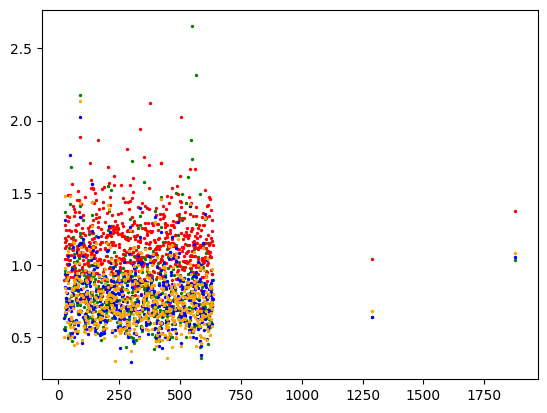

In [ ]:
fig, ax = plt.subplots()
ax.scatter(users_bst,val_bst_loss, color='green', s=2)
ax.scatter(users_ngcf,val_ngcf_loss, color='red', s=2)
ax.scatter(users_bst_ngcf,val_ngcf_bst_loss, color='blue', s=2)
ax.scatter(users_bst_ngcf_kg,val_ngcf_bst_kg_loss, color='orange', s=2)
plt.show()

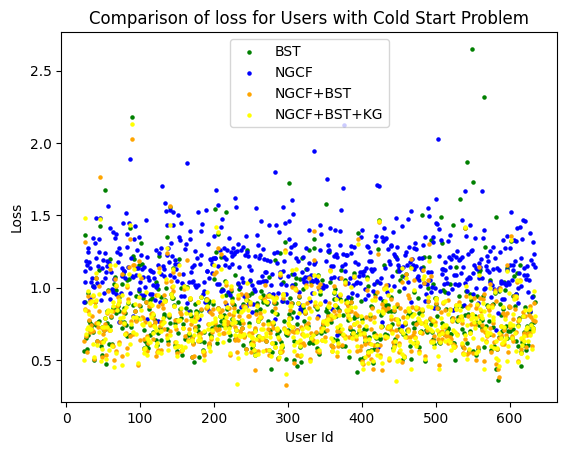

In [ ]:
fig, ax = plt.subplots()
ax.scatter(plot_users_val_bst,plot_val_bst_loss, color='green', s=5, label="BST")
ax.scatter(plot_users_val_ngcf,plot_val_ngcf_loss, color='blue', s=5, label="NGCF")
ax.scatter(plot_users_val_ngcf_bst,plot_val_ngcf_bst_loss, color='orange', s=5, label="NGCF+BST")
ax.scatter(plot_users_val_ngcf_bst_kg,plot_val_ngcf_bst_kg_loss, color='yellow', s=5, label="NGCF+BST+KG")
ax.legend()

plt.title("Comparison of loss for Users with Cold Start Problem")
plt.xlabel("User Id")
plt.ylabel("Loss")
plt.show()

In [ ]:
import random
sample_size = 100

In [ ]:
plot_val_bst = list(zip(plot_users_val_bst, plot_val_bst_loss))
val_bst_sample = random.sample(plot_val_bst, sample_size)
sub_plot_users_val_bst, sub_plot_val_bst_loss = zip(*val_bst_sample)


plot_val_ngcf = list(zip(plot_users_val_ngcf,plot_val_ngcf_loss))
val_ngcf_sample = random.sample(plot_val_ngcf, sample_size)
sub_plot_users_val_ngcf, sub_plot_val_ngcf_loss = zip(*val_ngcf_sample)

plot_val_bst_ngcf = list(zip(plot_users_val_ngcf_bst,plot_val_ngcf_bst_loss))
val_ngcf_bst_sample = random.sample(plot_val_bst_ngcf, sample_size)
sub_plot_users_val_bst_ngcf, sub_plot_val_bst_ngcf_loss = zip(*val_ngcf_bst_sample)


plot_val_bst_ngcf_kg = list(zip(plot_users_val_ngcf_bst_kg,plot_val_ngcf_bst_kg_loss))
plot_val_bst_ngcf_kg_sample = random.sample(plot_val_bst_ngcf_kg, sample_size)
sub_plot_users_val_bst_ngcf_kg, sub_plot_val_bst_ngcf_loss_kg = zip(*plot_val_bst_ngcf_kg_sample)


In [ ]:
val_mean_bst = np.mean(plot_val_bst_loss)
val_mean_ngcf = np.mean(plot_val_ngcf_loss)
val_mean_bst_ngcf = np.mean(plot_val_ngcf_bst_loss)
val_mean_bst_ngcf_kg = np.mean(plot_val_ngcf_bst_kg_loss)


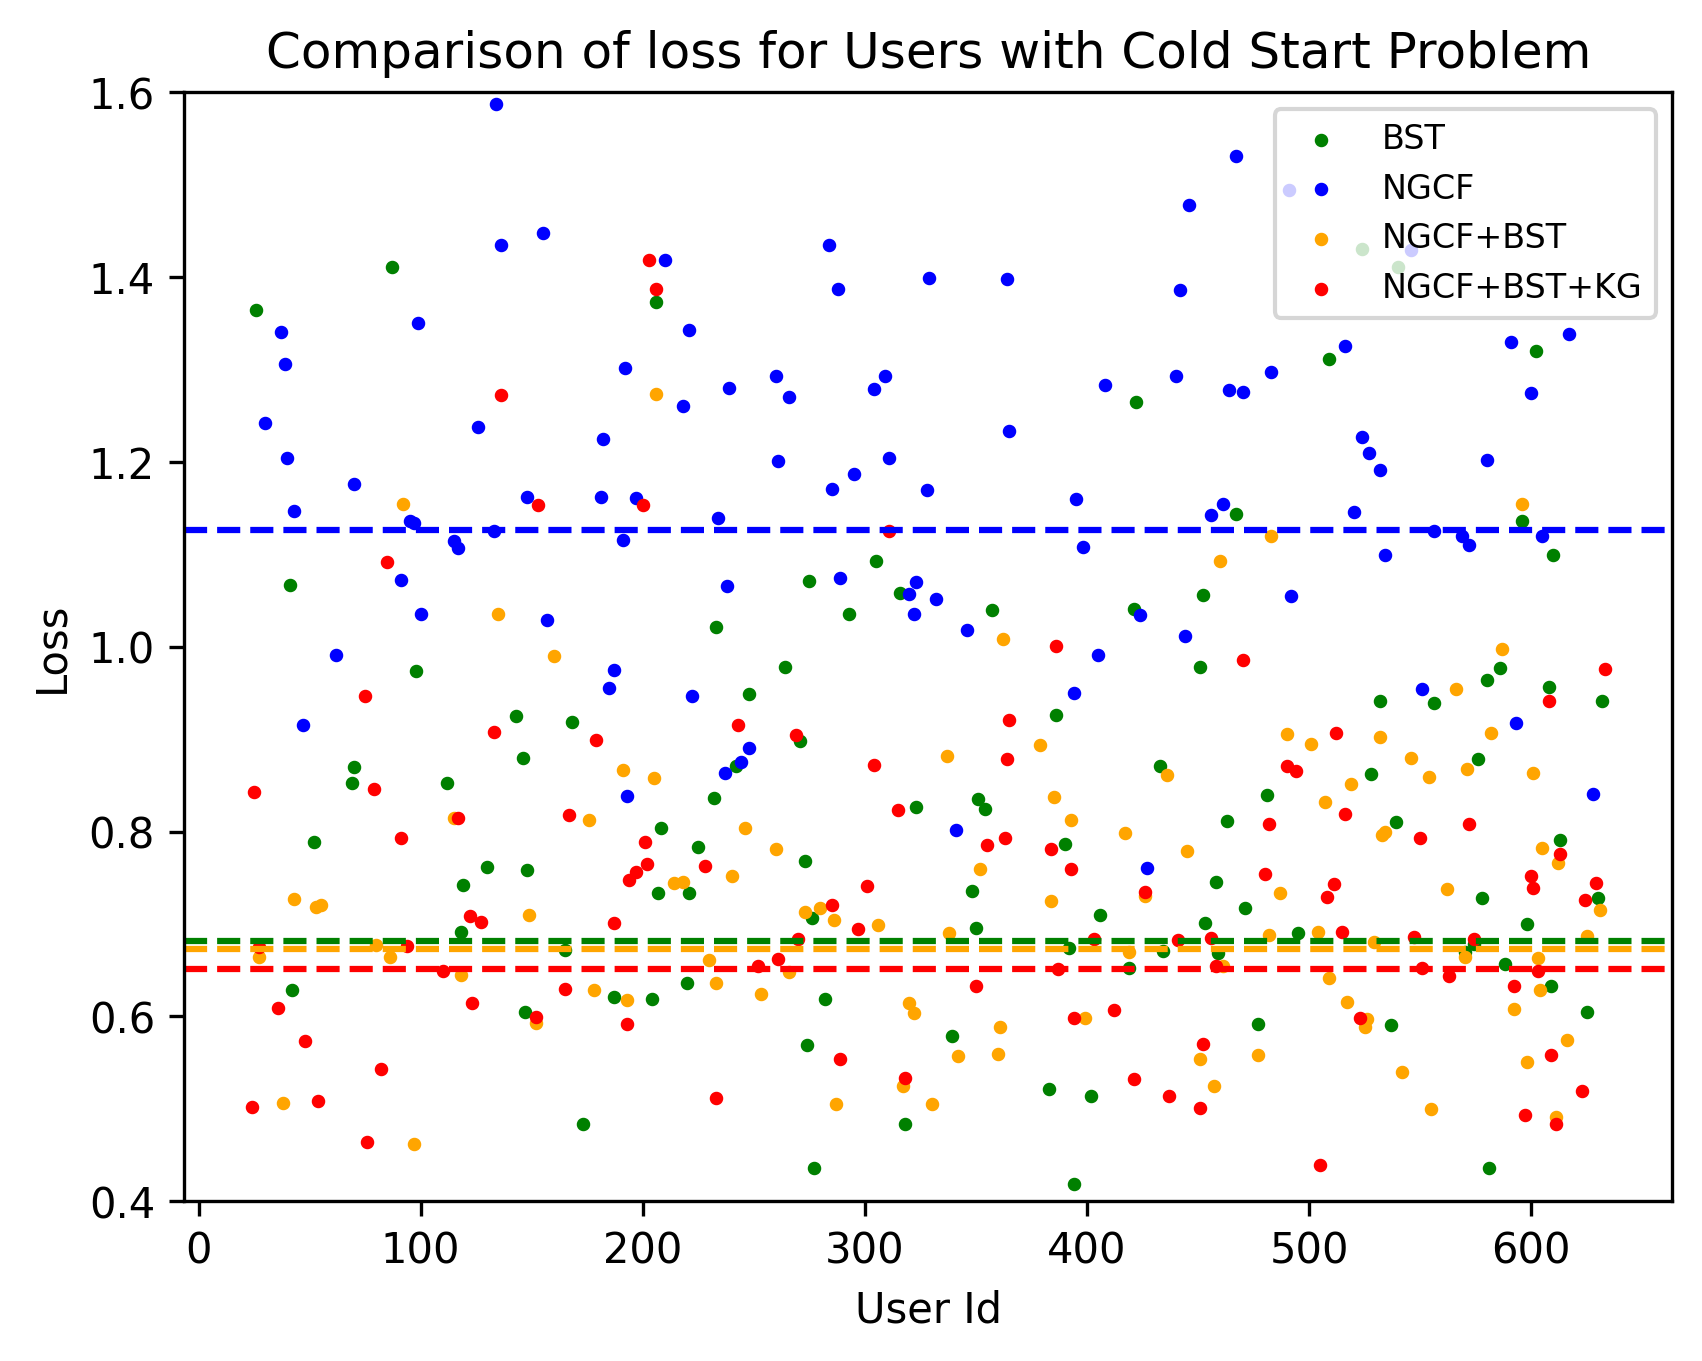

In [ ]:
fig, ax = plt.subplots(dpi=300)

ax.scatter(sub_plot_users_val_bst,sub_plot_val_bst_loss, color='green', s=5, label="BST")
ax.scatter(sub_plot_users_val_ngcf,sub_plot_val_ngcf_loss, color='blue', s=5, label="NGCF")
ax.scatter(sub_plot_users_val_bst_ngcf,sub_plot_val_bst_ngcf_loss, color='orange', s=5, label="NGCF+BST")
ax.scatter(sub_plot_users_val_bst_ngcf_kg,sub_plot_val_bst_ngcf_loss_kg, color='red', s=5, label="NGCF+BST+KG")


ax.axhline(y=val_mean_bst, color='green', linestyle='--', label="BST Mean")
ax.axhline(y=val_mean_ngcf, color='blue', linestyle='--', label="NGCF Mean")
ax.axhline(y=val_mean_bst_ngcf, color='red', linestyle='--', label="NGCF+BST Mean")
ax.axhline(y=val_mean_bst_ngcf_kg, color='orange', linestyle='--', label="NGCF+BST+KG Mean")

plt.legend(["BST", "NGCF", "NGCF+BST", "NGCF+BST+KG"], prop={'size': 8})


plt.ylim(0.4,1.6)


plt.title("Comparison of loss for Users with Cold Start Problem")
plt.xlabel("User Id")
plt.ylabel("Loss")
plt.show()


In [ ]:
 #cold start problem for test set

users_in_test_not_train = list(test_users.difference(train_users))

count = 0
no_bst = 0
diff = []


test_bst_loss = []
test_ngcf_loss = []
test_ngcf_bst_loss = []
test_ngcf_bst_kg_loss = []

users_bst = []
users_ngcf = []
users_bst_ngcf = []
users_bst_ngcf_kg = []


for user in users_in_test_not_train:
  
  if user in bst_test_loss_map:
    test_bst_loss.append(bst_test_loss_map[user][0])
    users_bst.append(user)


  test_ngcf_loss.append(ngcf_test_user_loss[user])
  users_ngcf.append(user)


  if user in ngcf_bst_test_user_loss:
    test_ngcf_bst_loss.append(ngcf_bst_test_user_loss[user])
    users_bst_ngcf.append(user)

  if user in test_bst_ngcf_kg_user_loss:
    test_ngcf_bst_kg_loss.append(test_bst_ngcf_kg_user_loss[user])
    users_bst_ngcf_kg.append(user)


print("Total number of users with cold start problem in validation set: ", len(users_in_test_not_train))


Total number of users with cold start problem in validation set:  200


In [ ]:
plot_users_test_bst = []
plot_users_test_ngcf = []
plot_users_test_ngcf_bst = []
plot_users_test_ngcf_bst_kg = []



plot_test_bst_loss = []
plot_test_ngcf_loss = []
plot_test_ngcf_bst_loss = []
plot_test_ngcf_bst_kg_loss = []




for i in range(len(users_bst)):
  if users_bst[i]<1000:
    plot_users_test_bst.append(users_bst[i])
    plot_test_bst_loss.append(test_bst_loss[i])

for i in range(len(users_ngcf)):
  if users_ngcf[i]<1000:
    plot_users_test_ngcf.append(users_ngcf[i])
    plot_test_ngcf_loss.append(test_ngcf_loss[i])

for i in range(len(users_bst_ngcf)):
  if users_bst_ngcf[i]<1000:
    plot_users_test_ngcf_bst.append(users_bst_ngcf[i])
    plot_test_ngcf_bst_loss.append(test_ngcf_bst_loss[i])

for i in range(len(users_bst_ngcf_kg)):
  if users_bst_ngcf_kg[i]<1000:
    plot_users_test_ngcf_bst_kg.append(users_bst_ngcf[i])
    plot_test_ngcf_bst_kg_loss.append(test_ngcf_bst_kg_loss[i])




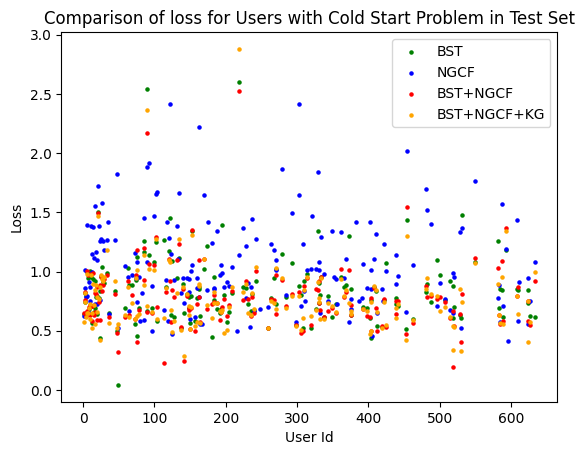

In [ ]:
fig, ax = plt.subplots()
ax.scatter(plot_users_test_bst,plot_test_bst_loss, color='green', s=5, label="BST")
ax.scatter(plot_users_test_ngcf,plot_test_ngcf_loss, color='blue', s=5, label="NGCF")
ax.scatter(plot_users_test_ngcf_bst,plot_test_ngcf_bst_loss, color='red', s=5, label="BST+NGCF")
ax.scatter(plot_users_test_ngcf_bst_kg,plot_test_ngcf_bst_kg_loss, color='orange', s=5, label="BST+NGCF+KG")

ax.legend()
plt.title("Comparison of loss for Users with Cold Start Problem in Test Set")
plt.xlabel("User Id")
plt.ylabel("Loss")
plt.show()

## Comparison performance for all users

### Validation Set

In [ ]:
user_lst = val_users.intersection(train_users)

count = 0
no_bst = 0
diff = []

users_bst = []
users_ngcf = []
users_bst_ngcf = []
users_bst_ngcf_kg = []


val_bst_loss = []
val_ngcf_loss = []
val_ngcf_bst_loss = []
val_ngcf_bst_kg_loss = []

for user in list(user_lst):

  if user in bst_val_loss_map:
    val_bst_loss.append(bst_val_loss_map[user][0])
    users_bst.append(user)

  val_ngcf_loss.append(ngcf_val_user_loss[user])
  users_ngcf.append(user)

  if user in ngcf_bst_val_user_loss:
    val_ngcf_bst_loss.append(ngcf_bst_val_user_loss[user])
    users_bst_ngcf.append(user)

  if user in val_bst_ngcf_kg_user_loss:
    val_ngcf_bst_kg_loss.append(val_bst_ngcf_kg_user_loss[user])
    users_bst_ngcf_kg.append(user)



print("Total number of users in validation set with training data : ", len(user_lst))


Total number of users in validation set with training data :  523


In [ ]:
plot_users_val_bst = []
plot_users_val_ngcf = []
plot_users_val_ngcf_bst = []
plot_users_val_ngcf_bst_kg = []

plot_val_bst_loss = []
plot_val_ngcf_loss = []
plot_val_ngcf_bst_loss = []
plot_val_ngcf_bst_kg_loss = []

plot_user_sample_bst = []
plot_user_sample_ngcf = []
plot_user_sample_bst_ngcf = []
plot_user_sample_bst_ngcf_kg = []


for i in range(len(users_bst)):
  if users_bst[i]<1000:
    plot_users_val_bst.append(users_bst[i])
    plot_val_bst_loss.append(val_bst_loss[i])
    plot_user_sample_bst.append(train_user_samples[(users_bst[i],users_bst[i]) ])

for i in range(len(users_ngcf)):
  if users_ngcf[i]<1000:
    plot_users_val_ngcf.append(users_ngcf[i])
    plot_val_ngcf_loss.append(val_ngcf_loss[i])
    plot_user_sample_ngcf.append(train_user_samples[(users_ngcf[i],users_ngcf[i])])


for i in range(len(users_bst_ngcf)):
  if users_bst_ngcf[i]<1000:
    plot_users_val_ngcf_bst.append(users_bst_ngcf[i])
    plot_val_ngcf_bst_loss.append([val_ngcf_bst_loss[i]])
    plot_user_sample_bst_ngcf.append(train_user_samples[(users_bst_ngcf[i],users_bst_ngcf[i])])

for i in range(len(users_bst_ngcf_kg)):
  if users_bst_ngcf_kg[i]<1000:
    plot_users_val_ngcf_bst_kg.append(users_bst_ngcf[i])
    plot_val_ngcf_bst_kg_loss.append([val_ngcf_bst_kg_loss[i]])
    plot_user_sample_bst_ngcf_kg.append(train_user_samples[(users_bst_ngcf_kg[i],users_bst_ngcf_kg[i])])




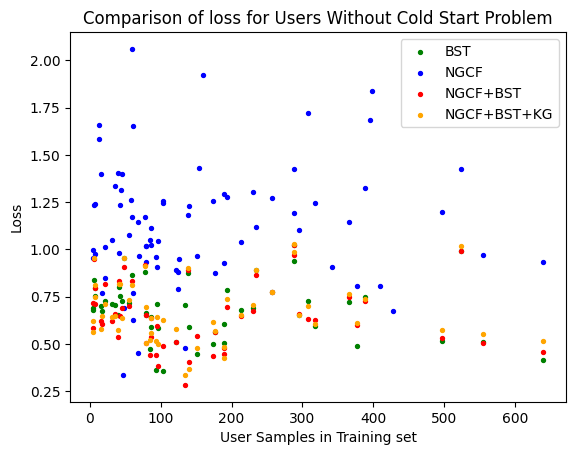

In [ ]:
fig, ax = plt.subplots()
ax.scatter(plot_user_sample_bst,plot_val_bst_loss, color='green', s=8, label="BST")
ax.scatter(plot_user_sample_ngcf,plot_val_ngcf_loss, color='blue', s=8, label="NGCF")
ax.scatter(plot_user_sample_bst_ngcf,plot_val_ngcf_bst_loss, color='red', s=8, label="NGCF+BST")
ax.scatter(plot_user_sample_bst_ngcf_kg,plot_val_ngcf_bst_kg_loss, color='orange', s=8, label="NGCF+BST+KG")

ax.legend()

plt.title("Comparison of loss for Users Without Cold Start Problem")
plt.xlabel("User Samples in Training set")
plt.ylabel("Loss")
plt.show()

In [ ]:
val_mean_bst = np.mean(plot_val_bst_loss)
val_mean_ngcf = np.mean(plot_val_ngcf_loss)
val_mean_bst_ngcf = np.mean(plot_val_ngcf_bst_loss)
val_mean_bst_ngcf_kg = np.mean(plot_val_ngcf_bst_kg_loss)


In [ ]:
val_bst_coefficients = np.polyfit(plot_user_sample_bst, plot_val_bst_loss, 1)
val_bst_p = np.poly1d(val_bst_coefficients)

val_ngcf_coefficients = np.polyfit(plot_user_sample_ngcf, plot_val_ngcf_loss, 1)
val_ngcf_p = np.poly1d(val_ngcf_coefficients)


val_bst_ngcf_coefficients = np.polyfit(plot_user_sample_bst_ngcf, np.asarray(plot_val_ngcf_bst_loss).squeeze(), 1)
val_ngcf_bst_p = np.poly1d(val_bst_ngcf_coefficients)


val_bst_ngcf_kg_coefficients = np.polyfit(plot_user_sample_bst_ngcf_kg, np.asarray(plot_val_ngcf_bst_kg_loss).squeeze(), 1)
val_ngcf_bst_kg_p = np.poly1d(val_bst_ngcf_kg_coefficients)






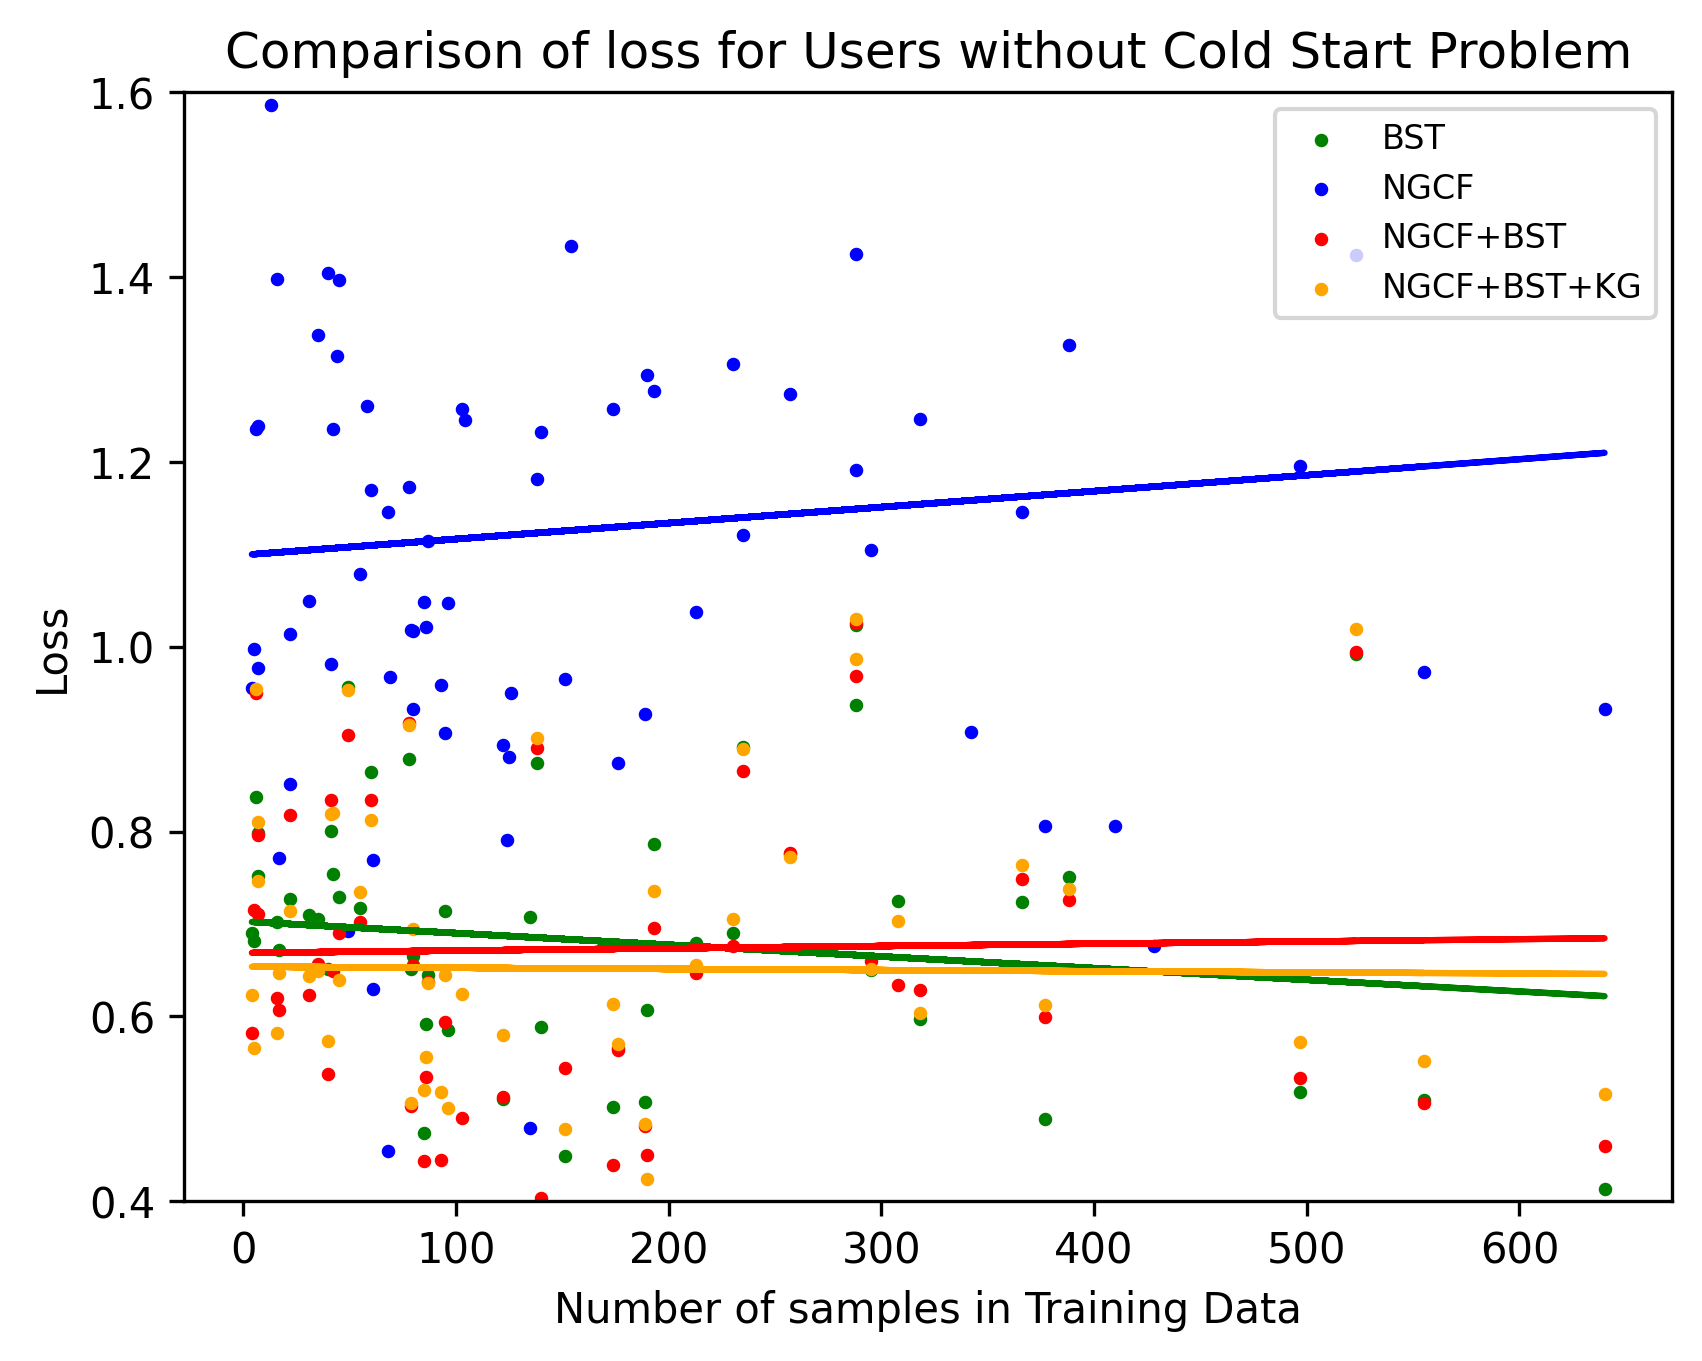

In [ ]:
fig, ax = plt.subplots(dpi=300)

ax.scatter(plot_user_sample_bst,plot_val_bst_loss, color='green', s=5, label="BST")
ax.scatter(plot_user_sample_ngcf,plot_val_ngcf_loss, color='blue', s=5, label="NGCF")
ax.scatter(plot_user_sample_bst_ngcf,plot_val_ngcf_bst_loss, color='red', s=5, label="NGCF+BST")
ax.scatter(plot_user_sample_bst_ngcf_kg,plot_val_ngcf_bst_kg_loss, color='orange', s=5, label="NGCF+BST+KG")

plt.plot(plot_user_sample_bst, val_bst_p(plot_user_sample_bst), color='green', linestyle= "-")
plt.plot(plot_user_sample_ngcf, val_ngcf_p(plot_user_sample_ngcf), color='blue', linestyle= "-")
plt.plot(plot_user_sample_bst_ngcf, val_ngcf_bst_p(plot_user_sample_bst_ngcf), color='orange', linestyle= "-")
plt.plot(plot_user_sample_bst_ngcf_kg, val_ngcf_bst_kg_p(plot_user_sample_bst_ngcf_kg), color='red', linestyle= "-")


plt.legend(["BST", "NGCF", "NGCF+BST", "NGCF+BST+KG"], prop={'size': 8})


plt.ylim(0.4,1.6)


plt.title("Comparison of loss for Users without Cold Start Problem")
plt.xlabel("Number of samples in Training Data")
plt.ylabel("Loss")
plt.show()
